In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import remove_stopwords
import contractions
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
import numpy as np
import fasttext
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

sns.set_theme()

%matplotlib inline

In [2]:
def calculate_accuracy_precision_recall(true_labels, predicted_labels):
    return (accuracy_score(true_labels, predicted_labels),
           precision_score(true_labels, predicted_labels),
           recall_score(true_labels, predicted_labels))

## Load dataset

In [3]:
df = pd.read_csv('samples.csv')
# bug == 0 and feature == 1
df = df[(df['label'] == 0) | (df['label'] == 1)]
#df = df[:50]
len(df)

407799

## Preprocess dataset

In [4]:
contractions.add('__label__', 'REMOVED_TOKEN')

In [5]:
# fix contractions
df['title'] = df['title'].apply(contractions.fix)
df['body'] = df['body'].apply(contractions.fix)

In [6]:
# removal of stopwords
df['title'] = df['title'].apply(remove_stopwords)
df['body'] = df['body'].apply(remove_stopwords)

## Generate statistics

In [7]:
df['number_of_words_of_title'] = df['title'].str.split().str.len()
df['number_of_words_of_body'] = df['body'].str.split().str.len()

Text(0.5, 0, 'Number of words of title')

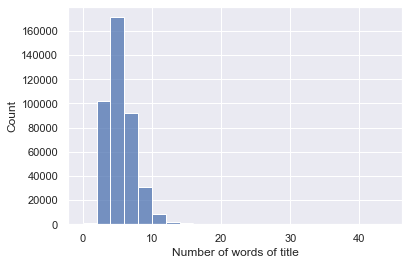

In [8]:
fig = sns.histplot(data=df, x='number_of_words_of_title', kde=False, stat='count', binwidth=2)
fig.set_xlabel('Number of words of title')
#fig.get_figure().savefig('figures/price_kde_histogram.jpg', dpi=500)

Text(0.5, 0, 'Number of words of body')

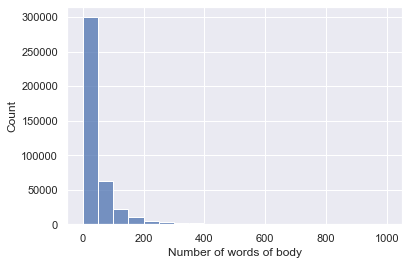

In [9]:
fig = sns.histplot(data=df, x='number_of_words_of_body', kde=False, stat='count', binwidth=50)
fig.set_xlabel('Number of words of body')
#fig.get_figure().savefig('figures/price_kde_histogram.jpg', dpi=500)

In [10]:
# bugs == 0
# feature == 1
df['label'].value_counts()

1    207318
0    200481
Name: label, dtype: int64

## Train fasttext embeddings

In [11]:
df['fasttext_input'] = '__label__' + df['label'].map(str) + ' ' + df['title'] + ' ' + df['body']
train_input, test_input = train_test_split(df.fasttext_input.values, test_size=0.33, random_state=42)
np.savetxt('train.txt', train_input, fmt='%s')
np.savetxt('test.txt', test_input, fmt='%s')
fasttext_model = fasttext.train_supervised('train.txt')
fasttext_model.test('test.txt')
df.drop('fasttext_input', axis=1, inplace=True)

Read 14M words
Number of words:  1516952
Number of labels: 2
Progress: 100.0% words/sec/thread: 1253185 lr:  0.000000 avg.loss:  0.369880 ETA:   0h 0m 0s


## Train baseline models

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.body, df.label, test_size=0.33, random_state=42)
tfidf_vectorizer = TfidfVectorizer()
scaler = MaxAbsScaler()
X_train = tfidf_vectorizer.fit_transform(X_train)
X_train = scaler.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)
X_test = scaler.transform(X_test)

### Tf-idf logistic regression classification

In [13]:
logit_clf = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)
predicted_labels = logit_clf.predict(X_test)
true_labels = y_test
calculate_accuracy_precision_recall(true_labels, predicted_labels)

(0.7953467980441987, 0.8027159729287389, 0.79357744672167)

### Fasttext + logistic regression classification

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df.body, df.label, test_size=0.33, random_state=42)
X_train = [fasttext_model.get_sentence_vector(s) for s in X_train.values]
X_test = [fasttext_model.get_sentence_vector(s) for s in X_test.values]
logit_clf = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)
predicted_labels = logit_clf.predict(X_test)
true_labels = y_test
calculate_accuracy_precision_recall(true_labels, predicted_labels)

(0.7972342354392379, 0.8084728299012947, 0.7892043963732835)

### Fasttext classification

In [15]:
_, test_df = train_test_split(df, test_size=0.33, random_state=42)
predicted_labels = [int(res[0].split('__label__')[1]) for res in fasttext_model.predict(test_df['body'].values.tolist())[0]]
true_labels = test_df['label'].values
calculate_accuracy_precision_recall(true_labels, predicted_labels)

(0.7968329692213949, 0.8121812816826814, 0.7823824378298009)

## Train our model

## Evaluation results

In [ ]:
df['number_of_words_of_title'].describe(percentiles=[0.15, 0.85])

In [ ]:
df['number_of_words_of_title'].quantile(0.8)

In [ ]:
new_df = df[(df['number_of_words_of_title'] > df['number_of_words_of_title'].quantile(0.01)) & (df['number_of_words_of_title'] < df['number_of_words_of_title'].quantile(0.99))]

In [ ]:
df['title'].str.split().str.len().quantile(0.25)